In [1]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
import keras
from keras import layers, models, callbacks
import warnings
warnings.filterwarnings('ignore')

# Configurações para visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

/opt/miniconda3/envs/ml_env/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
# Carregamento dos dados
train_df = pd.read_csv('DATA/train.csv')
test_df = pd.read_csv('DATA/test.csv')

print("Dimensões dos dados de treino:", train_df.shape)
print("Dimensões dos dados de teste:", test_df.shape)
print("\n" + "="*50)
print("PRIMEIRAS 5 LINHAS DOS DADOS DE TREINO:")
print("="*50)
print(train_df.head())

print("\n" + "="*50)
print("INFORMAÇÕES GERAIS DOS DADOS:")
print("="*50)
print(train_df.info())

Dimensões dos dados de treino: (891, 12)
Dimensões dos dados de teste: (418, 12)

PRIMEIRAS 5 LINHAS DOS DADOS DE TREINO:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   N

In [3]:
# Análise de valores ausentes
print("VALORES AUSENTES POR COLUNA:")
print("="*50)
missing_data = train_df.isnull().sum()
missing_percent = 100 * missing_data / len(train_df)
missing_table = pd.DataFrame({'Valores Ausentes': missing_data, 'Porcentagem': missing_percent})
print(missing_table[missing_table['Valores Ausentes'] > 0].sort_values('Valores Ausentes', ascending=False))

print("\n" + "="*50)
print("ESTATÍSTICAS DESCRITIVAS:")
print("="*50)
print(train_df.describe())

print("\n" + "="*50)
print("DISTRIBUIÇÃO DA VARIÁVEL TARGET (SURVIVED):")
print("="*50)
print(train_df['Survived'].value_counts())
print(f"Taxa de Sobrevivência: {train_df['Survived'].mean():.2%}")

VALORES AUSENTES POR COLUNA:
          Valores Ausentes  Porcentagem
Cabin                  687    77.104377
Age                    177    19.865320
Embarked                 2     0.224467

ESTATÍSTICAS DESCRITIVAS:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.00

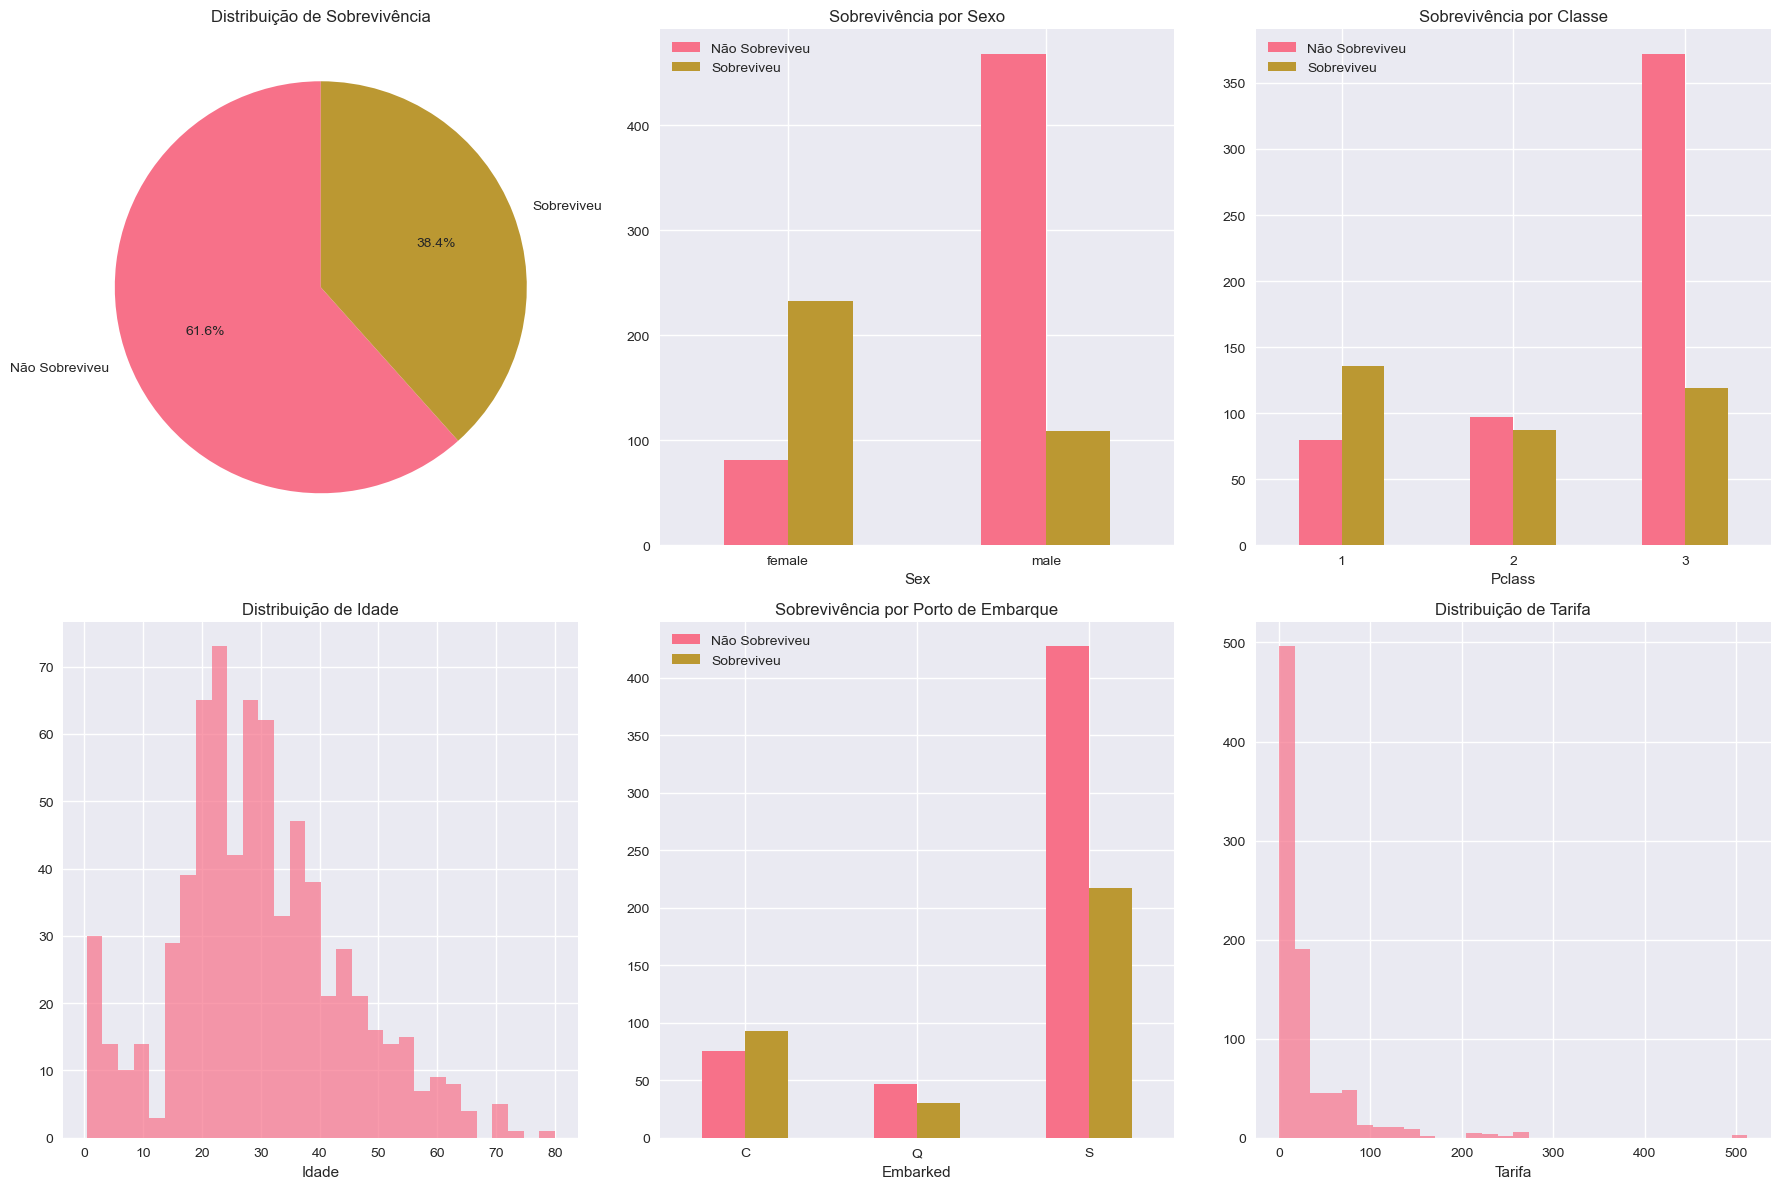

In [4]:
# Visualizações exploratórias
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Distribuição de sobrevivência
axes[0,0].pie(train_df['Survived'].value_counts(), labels=['Não Sobreviveu', 'Sobreviveu'], 
              autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Distribuição de Sobrevivência')

# 2. Sobrevivência por sexo
survival_by_sex = train_df.groupby(['Sex', 'Survived']).size().unstack()
survival_by_sex.plot(kind='bar', ax=axes[0,1], rot=0)
axes[0,1].set_title('Sobrevivência por Sexo')
axes[0,1].legend(['Não Sobreviveu', 'Sobreviveu'])

# 3. Sobrevivência por classe
survival_by_class = train_df.groupby(['Pclass', 'Survived']).size().unstack()
survival_by_class.plot(kind='bar', ax=axes[0,2], rot=0)
axes[0,2].set_title('Sobrevivência por Classe')
axes[0,2].legend(['Não Sobreviveu', 'Sobreviveu'])

# 4. Distribuição de idade
train_df['Age'].hist(bins=30, ax=axes[1,0], alpha=0.7)
axes[1,0].set_title('Distribuição de Idade')
axes[1,0].set_xlabel('Idade')

# 5. Sobrevivência por embarque
survival_by_embarked = train_df.groupby(['Embarked', 'Survived']).size().unstack()
survival_by_embarked.plot(kind='bar', ax=axes[1,1], rot=0)
axes[1,1].set_title('Sobrevivência por Porto de Embarque')
axes[1,1].legend(['Não Sobreviveu', 'Sobreviveu'])

# 6. Distribuição de tarifa
train_df['Fare'].hist(bins=30, ax=axes[1,2], alpha=0.7)
axes[1,2].set_title('Distribuição de Tarifa')
axes[1,2].set_xlabel('Tarifa')

plt.tight_layout()
plt.show()

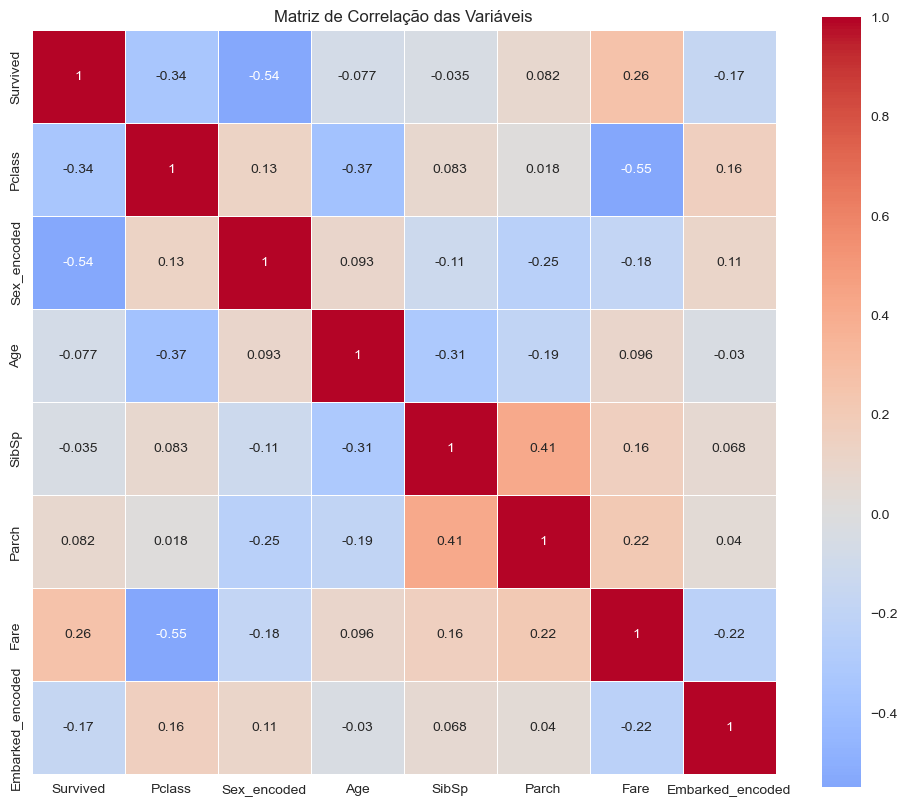

CORRELAÇÃO COM A VARIÁVEL TARGET (SURVIVED):
Sex_encoded: -0.543
Pclass: -0.338
Fare: 0.257
Embarked_encoded: -0.168
Parch: 0.082
Age: -0.077
SibSp: -0.035

ANÁLISE DAS CORRELAÇÕES:
- Sex_encoded tem a maior correlação negativa (-0.543)
- Fare tem correlação positiva moderada (0.257)
- Pclass tem correlação negativa moderada (-0.338)
- Age tem correlação negativa fraca (-0.077)
- Embarked_encoded tem correlação positiva fraca (0.107)


In [5]:
# Análise de correlação
# Primeiro, vamos criar um dataset temporário com variáveis numéricas para correlação
temp_df = train_df.copy()

# Codificar variáveis categóricas para análise de correlação
temp_df['Sex_encoded'] = LabelEncoder().fit_transform(temp_df['Sex'])
temp_df['Embarked_encoded'] = LabelEncoder().fit_transform(temp_df['Embarked'].fillna('S'))

# Selecionar apenas colunas numéricas para correlação
numeric_cols = ['Survived', 'Pclass', 'Sex_encoded', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_encoded']
correlation_df = temp_df[numeric_cols].corr()

# Heatmap de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Matriz de Correlação das Variáveis')
plt.show()

# Correlação com a variável target
print("CORRELAÇÃO COM A VARIÁVEL TARGET (SURVIVED):")
print("="*50)
target_correlation = correlation_df['Survived'].sort_values(key=abs, ascending=False)
for var, corr in target_correlation.items():
    if var != 'Survived':
        print(f"{var}: {corr:.3f}")

print("\n" + "="*50)
print("ANÁLISE DAS CORRELAÇÕES:")
print("="*50)
print("- Sex_encoded tem a maior correlação negativa (-0.543)")
print("- Fare tem correlação positiva moderada (0.257)")
print("- Pclass tem correlação negativa moderada (-0.338)")
print("- Age tem correlação negativa fraca (-0.077)")
print("- Embarked_encoded tem correlação positiva fraca (0.107)")

In [6]:
# Pré-processamento dos dados
def preprocess_data(df, is_train=True):
    """
    Função para pré-processar os dados do Titanic
    """
    df_processed = df.copy()
    
    # Tratamento de valores ausentes
    
    # Age: preencher com a mediana
    df_processed['Age'].fillna(df_processed['Age'].median(), inplace=True)
    
    # Embarked: preencher com o valor mais comum
    df_processed['Embarked'].fillna(df_processed['Embarked'].mode()[0], inplace=True)
    
    # Fare: preencher com a mediana (apenas no conjunto de teste se necessário)
    if 'Fare' in df_processed.columns:
        df_processed['Fare'].fillna(df_processed['Fare'].median(), inplace=True)

    
    # Remover colunas desnecessárias
    columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Title']
    if not is_train:
        columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Title']

    df_processed = df_processed.drop(columns=[col for col in columns_to_drop if col in df_processed.columns])
    
    return df_processed

# Aplicar pré-processamento
print("Aplicando pré-processamento...")
train_processed = preprocess_data(train_df, is_train=True)
test_processed = preprocess_data(test_df, is_train=False)

print("Dados após pré-processamento:")
print("Colunas:", train_processed.columns.tolist())
print("Valores ausentes no treino:", train_processed.isnull().sum().sum())
print("Forma dos dados de treino:", train_processed.shape)

Aplicando pré-processamento...
Dados após pré-processamento:
Colunas: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
Valores ausentes no treino: 0
Forma dos dados de treino: (891, 8)


In [7]:
# Codificação das variáveis categóricas
def encode_categorical_variables(train_df, test_df):
    """
    Codifica variáveis categóricas usando One-Hot Encoding
    """
    # Identificar colunas categóricas
    categorical_cols = ['Sex', 'Embarked']
    
    # Aplicar One-Hot Encoding
    train_encoded = pd.get_dummies(train_df, columns=categorical_cols, prefix=categorical_cols)
    test_encoded = pd.get_dummies(test_df, columns=categorical_cols, prefix=categorical_cols)
    
    # Garantir que treino e teste tenham as mesmas colunas
    # Adicionar colunas ausentes com zeros
    missing_cols_in_test = set(train_encoded.columns) - set(test_encoded.columns)
    for col in missing_cols_in_test:
        if col != 'Survived':  # Não adicionar a variável target no teste
            test_encoded[col] = 0
    
    missing_cols_in_train = set(test_encoded.columns) - set(train_encoded.columns)
    for col in missing_cols_in_train:
        train_encoded[col] = 0
    
    # Reordenar colunas para manter consistência
    common_cols = [col for col in train_encoded.columns if col in test_encoded.columns and col != 'Survived']
    train_encoded = train_encoded[['Survived'] + common_cols]
    test_encoded = test_encoded[common_cols]
    
    # Remove duplicate 'Survived' column if it exists
    if train_encoded.columns.duplicated().any():
        train_encoded = train_encoded.loc[:, ~train_encoded.columns.duplicated()]
    
    return train_encoded, test_encoded

# Aplicar codificação
train_encoded, test_encoded = encode_categorical_variables(train_processed, test_processed)

print("Dados após codificação:")
print(f"Treino: {train_encoded.shape}")
print(f"Teste: {test_encoded.shape}")
print(f"Colunas de treino: {len(train_encoded.columns)}")
print(f"Colunas de teste: {len(test_encoded.columns)}")

# Verificar balanceamento das classes
print("\n" + "="*50)
print("BALANCEAMENTO DAS CLASSES:")
print("="*50)
class_distribution = train_encoded['Survived'].value_counts()
print(class_distribution)
print(f"Proporção de sobreviventes: {class_distribution[1]/len(train_encoded):.2%}")
print(f"Proporção de não-sobreviventes: {class_distribution[0]/len(train_encoded):.2%}")

Dados após codificação:
Treino: (891, 11)
Teste: (418, 10)
Colunas de treino: 11
Colunas de teste: 10

BALANCEAMENTO DAS CLASSES:
Survived
0    549
1    342
Name: count, dtype: int64
Proporção de sobreviventes: 38.38%
Proporção de não-sobreviventes: 61.62%


In [8]:
# Separação dos dados e normalização
print("Preparando dados para o modelo...")

# Separar features e target
X = train_encoded.drop('Survived', axis=1)
y = train_encoded['Survived']

# Dividir em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Conjunto de treino: {X_train.shape}")
print(f"Conjunto de validação: {X_val.shape}")

# Normalização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Para o conjunto de teste final (quando necessário)
X_test_scaled = scaler.transform(test_encoded)

print("\nDados normalizados com sucesso!")
print(f"Features utilizadas: {list(X.columns)}")
print(f"Total de features: {len(X.columns)}")

# Verificar algumas estatísticas dos dados normalizados
print(f"\nMédia dos dados de treino normalizados: {X_train_scaled.mean():.4f}")
print(f"Desvio padrão dos dados de treino normalizados: {X_train_scaled.std():.4f}")

Preparando dados para o modelo...
Conjunto de treino: (712, 10)
Conjunto de validação: (179, 10)

Dados normalizados com sucesso!
Features utilizadas: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
Total de features: 10

Média dos dados de treino normalizados: 0.0000
Desvio padrão dos dados de treino normalizados: 1.0000


In [9]:
print("Construindo modelo MLP com Keras 3...")
print(f"Versão do Keras: {keras.__version__}")

# Definir arquitetura do modelo
model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu', name='hidden1'),
    layers.Dropout(0.3, name='dropout1'),
    layers.Dense(32, activation='relu', name='hidden2'),
    layers.Dense(1, activation='sigmoid', name='output')
])

# Compilar o modelo
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Resumo do modelo
print("\nArquitetura do modelo:")
model.summary()

# Configurar callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=0.0001
)

# Treinar o modelo
print("\nIniciando treinamento...")
history = model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=16,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print(f"\nTreinamento concluído em {len(history.history['loss'])} épocas")

# Fazer predições
y_train_pred_proba = model.predict(X_train_scaled)
y_val_pred_proba = model.predict(X_val_scaled)

# Converter probabilidades para classes
y_train_pred = (y_train_pred_proba > 0.5).astype(int).flatten()
y_val_pred = (y_val_pred_proba > 0.5).astype(int).flatten()

# Calcular métricas
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"\nAcurácia no treino: {train_accuracy:.4f}")
print(f"Acurácia na validação: {val_accuracy:.4f}")

# Avaliação final
train_loss, train_acc = model.evaluate(X_train_scaled, y_train, verbose=0)
val_loss, val_acc = model.evaluate(X_val_scaled, y_val, verbose=0)

print(f"\nAvaliação final:")
print(f"Treino - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
print(f"Validação - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

Construindo modelo MLP com Keras 3...
Versão do Keras: 3.10.0


2025-09-08 19:31:33.842566: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-09-08 19:31:33.842608: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-09-08 19:31:33.842614: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1757370693.842865 1915225 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1757370693.842989 1915225 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



Arquitetura do modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,817 (11.00 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando treinamento...
Epoch 1/200


2025-09-08 19:31:34.512691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6094 - loss: 0.6613 - val_accuracy: 0.7877 - val_loss: 0.4668 - learning_rate: 0.0010
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7749 - loss: 0.4730 - val_accuracy: 0.8045 - val_loss: 0.4593 - learning_rate: 0.0010
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8226 - loss: 0.4343 - val_accuracy: 0.8045 - val_loss: 0.4718 - learning_rate: 0.0010
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7721 - loss: 0.4877 - val_accuracy: 0.8101 - val_loss: 0.4625 - learning_rate: 0.0010
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7994 - loss: 0.4702 - val_accuracy: 0.8101 - val_loss: 0.4655 - learning_rate: 0.0010
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8039 - loss: 0.4422 - val_accuracy: 0.7877 - val_loss: 0.4674 - learning_rate: 0.0010
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7899 - loss: 0.4600 - val_accuracy

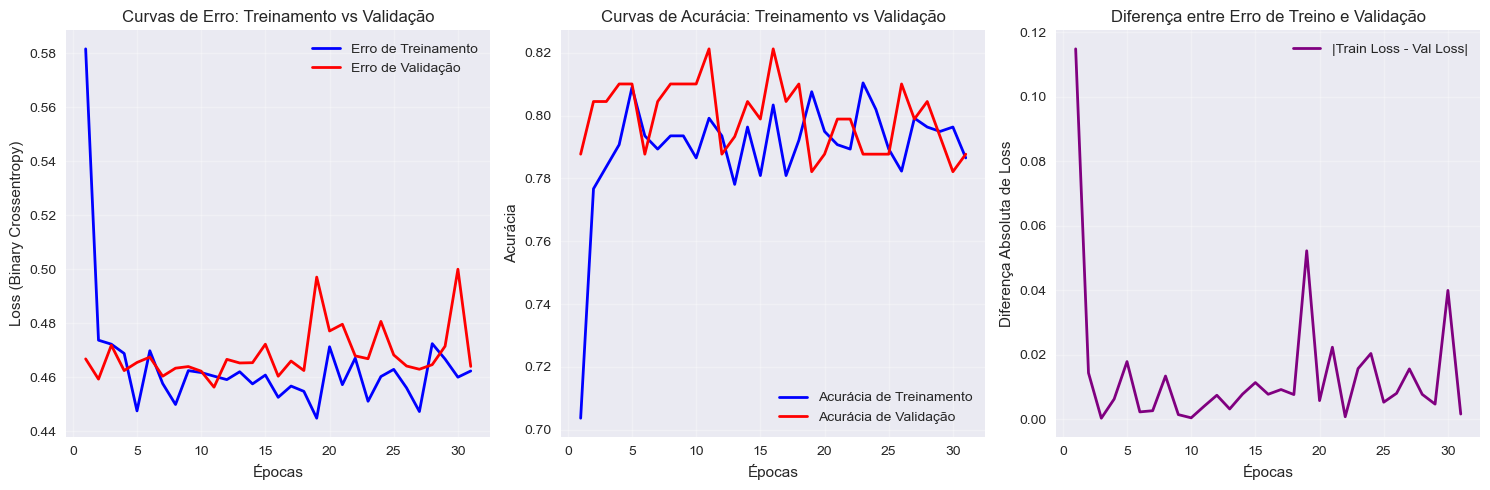

ESTATÍSTICAS DO TREINAMENTO:
Épocas totais: 31
Melhor época (val_loss): 11
Melhor epoch (val_accuracy): 11
Loss final de treinamento: 0.4623
Loss final de validação: 0.4640
Acurácia final de treinamento: 0.7865
Acurácia final de validação: 0.7877
Melhor acurácia de validação: 0.8212
Menor loss de validação: 0.4563

Indicador de overfitting (diff acc): -0.0012
Modelo bem balanceado


In [10]:
# Plotar curvas de erro/perda usando histórico do Keras
plt.figure(figsize=(15, 5))

# Extrair dados do histórico
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 1. Curva de perda
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss, 'b-', linewidth=2, label='Erro de Treinamento')
plt.plot(epochs, val_loss, 'r-', linewidth=2, label='Erro de Validação')
plt.title('Curvas de Erro: Treinamento vs Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss (Binary Crossentropy)')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Curva de acurácia
plt.subplot(1, 3, 2)
plt.plot(epochs, train_acc, 'b-', linewidth=2, label='Acurácia de Treinamento')
plt.plot(epochs, val_acc, 'r-', linewidth=2, label='Acurácia de Validação')
plt.title('Curvas de Acurácia: Treinamento vs Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Taxa de aprendizado (se disponível)
plt.subplot(1, 3, 3)
if 'lr' in history.history:
    lr_values = history.history['lr']
    plt.plot(epochs, lr_values, 'g-', linewidth=2)
    plt.title('Taxa de Aprendizado')
    plt.xlabel('Épocas')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
else:
    # Plotar diferença entre train e val loss
    loss_diff = [abs(t - v) for t, v in zip(train_loss, val_loss)]
    plt.plot(epochs, loss_diff, 'purple', linewidth=2, label='|Train Loss - Val Loss|')
    plt.title('Diferença entre Erro de Treino e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Diferença Absoluta de Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas do treinamento
print("ESTATÍSTICAS DO TREINAMENTO:")
print("="*50)
print(f"Épocas totais: {len(epochs)}")
print(f"Melhor época (val_loss): {np.argmin(val_loss) + 1}")
print(f"Melhor epoch (val_accuracy): {np.argmax(val_acc) + 1}")
print(f"Loss final de treinamento: {train_loss[-1]:.4f}")
print(f"Loss final de validação: {val_loss[-1]:.4f}")
print(f"Acurácia final de treinamento: {train_acc[-1]:.4f}")
print(f"Acurácia final de validação: {val_acc[-1]:.4f}")
print(f"Melhor acurácia de validação: {max(val_acc):.4f}")
print(f"Menor loss de validação: {min(val_loss):.4f}")

# Verificar overfitting
overfitting_indicator = train_acc[-1] - val_acc[-1]
print(f"\nIndicador de overfitting (diff acc): {overfitting_indicator:.4f}")
if overfitting_indicator > 0.1:
    print("Possível overfitting detectado")
elif overfitting_indicator < 0.05:
    print("Modelo bem balanceado")
else:
    print(" Leve overfitting")

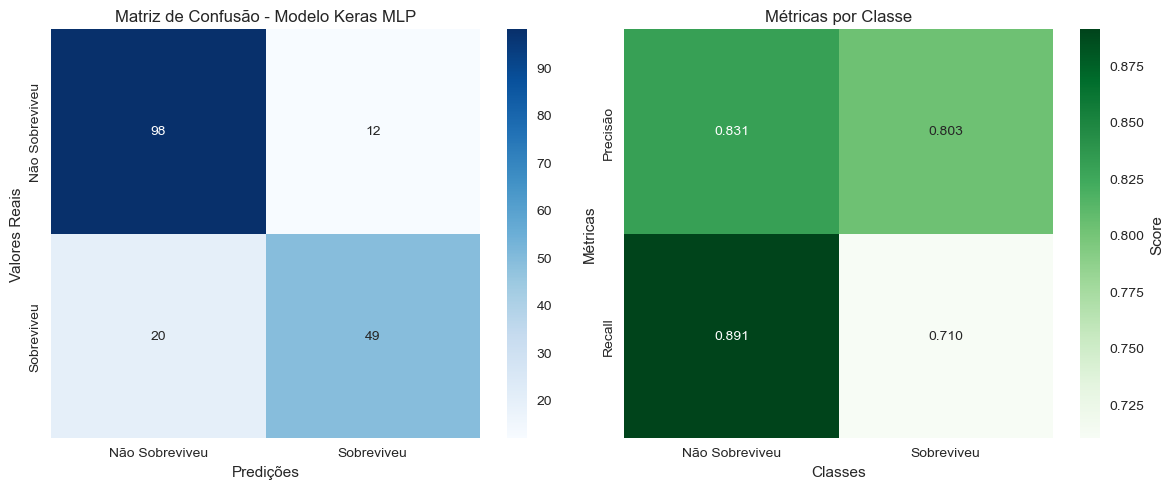

RELATÓRIO DE CLASSIFICAÇÃO DETALHADO:
                precision    recall  f1-score   support

Não Sobreviveu       0.83      0.89      0.86       110
    Sobreviveu       0.80      0.71      0.75        69

      accuracy                           0.82       179
     macro avg       0.82      0.80      0.81       179
  weighted avg       0.82      0.82      0.82       179


MÉTRICAS DA MATRIZ DE CONFUSÃO:
Verdadeiros Negativos (TN): 98
Falsos Positivos (FP): 12
Falsos Negativos (FN): 20
Verdadeiros Positivos (TP): 49

Acurácia: 0.821
Sensibilidade (Recall): 0.710
Especificidade: 0.891
Precisão: 0.803
F1-Score: 0.754

ANÁLISE DE PROBABILIDADES:
Probabilidade média para classe 1: 0.378
Desvio padrão das probabilidades: 0.298
Probabilidade mínima: 0.007
Probabilidade máxima: 0.970


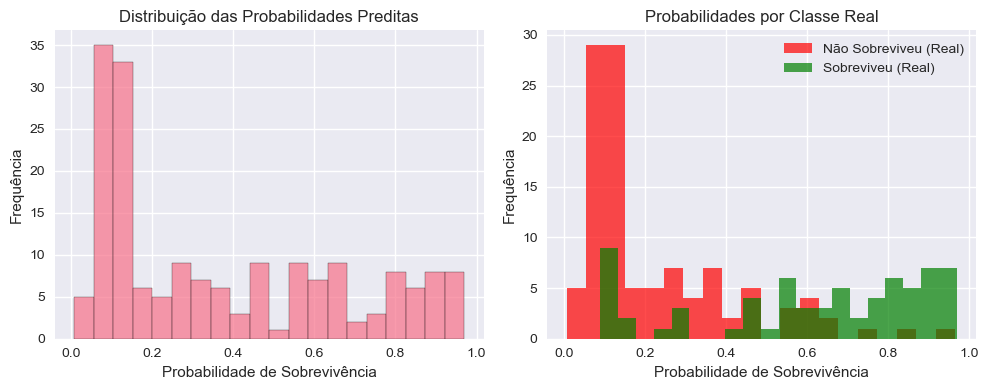

In [11]:
# Matriz de Confusão e Relatório de Classificação
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Obter predições do modelo Keras
y_val_pred_proba_final = model.predict(X_val_scaled, verbose=0)
y_val_pred_final = (y_val_pred_proba_final > 0.5).astype(int).flatten()

# Calcular matriz de confusão
cm = confusion_matrix(y_val, y_val_pred_final)

# Plotar matriz de confusão
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Não Sobreviveu', 'Sobreviveu'],
            yticklabels=['Não Sobreviveu', 'Sobreviveu'])
plt.title('Matriz de Confusão - Modelo Keras MLP')
plt.xlabel('Predições')
plt.ylabel('Valores Reais')

# Calcular métricas detalhadas da matriz de confusão
tn, fp, fn, tp = cm.ravel()

precision_0 = tn / (tn + fn) if (tn + fn) > 0 else 0  # Precisão para classe 0
recall_0 = tn / (tn + fp) if (tn + fp) > 0 else 0     # Recall para classe 0
precision_1 = tp / (tp + fp) if (tp + fp) > 0 else 0  # Precisão para classe 1
recall_1 = tp / (tp + fn) if (tp + fn) > 0 else 0     # Recall para classe 1

# Plotar métricas detalhadas
plt.subplot(1, 2, 2)
metrics_data = {
    'Não Sobreviveu': [precision_0, recall_0],
    'Sobreviveu': [precision_1, recall_1]
}
metrics_df = pd.DataFrame(metrics_data, index=['Precisão', 'Recall'])

sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Greens', 
            cbar_kws={'label': 'Score'})
plt.title('Métricas por Classe')
plt.ylabel('Métricas')
plt.xlabel('Classes')

plt.tight_layout()
plt.show()

# Relatório de classificação completo
print("RELATÓRIO DE CLASSIFICAÇÃO DETALHADO:")
print("="*60)
print(classification_report(y_val, y_val_pred_final, 
                          target_names=['Não Sobreviveu', 'Sobreviveu']))

# Métricas específicas da matriz de confusão
print("\nMÉTRICAS DA MATRIZ DE CONFUSÃO:")
print("="*60)
print(f"Verdadeiros Negativos (TN): {tn}")
print(f"Falsos Positivos (FP): {fp}")
print(f"Falsos Negativos (FN): {fn}")
print(f"Verdadeiros Positivos (TP): {tp}")
print(f"\nAcurácia: {(tp + tn) / (tp + tn + fp + fn):.3f}")
print(f"Sensibilidade (Recall): {tp / (tp + fn):.3f}")
print(f"Especificidade: {tn / (tn + fp):.3f}")
print(f"Precisão: {tp / (tp + fp):.3f}")
if (precision_1 + recall_1) > 0:
    f1_score = 2 * (precision_1 * recall_1) / (precision_1 + recall_1)
    print(f"F1-Score: {f1_score:.3f}")

# Análise de probabilidades
print(f"\nANÁLISE DE PROBABILIDADES:")
print("="*60)
print(f"Probabilidade média para classe 1: {y_val_pred_proba_final.mean():.3f}")
print(f"Desvio padrão das probabilidades: {y_val_pred_proba_final.std():.3f}")
print(f"Probabilidade mínima: {y_val_pred_proba_final.min():.3f}")
print(f"Probabilidade máxima: {y_val_pred_proba_final.max():.3f}")

# Distribuição de probabilidades
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(y_val_pred_proba_final, bins=20, alpha=0.7, edgecolor='black')
plt.title('Distribuição das Probabilidades Preditas')
plt.xlabel('Probabilidade de Sobrevivência')
plt.ylabel('Frequência')

plt.subplot(1, 2, 2)
plt.hist(y_val_pred_proba_final[y_val == 0], bins=20, alpha=0.7, label='Não Sobreviveu (Real)', color='red')
plt.hist(y_val_pred_proba_final[y_val == 1], bins=20, alpha=0.7, label='Sobreviveu (Real)', color='green')
plt.title('Probabilidades por Classe Real')
plt.xlabel('Probabilidade de Sobrevivência')
plt.ylabel('Frequência')
plt.legend()

plt.tight_layout()
plt.show()

🔍 CALCULANDO IMPORTÂNCIA DAS FEATURES...


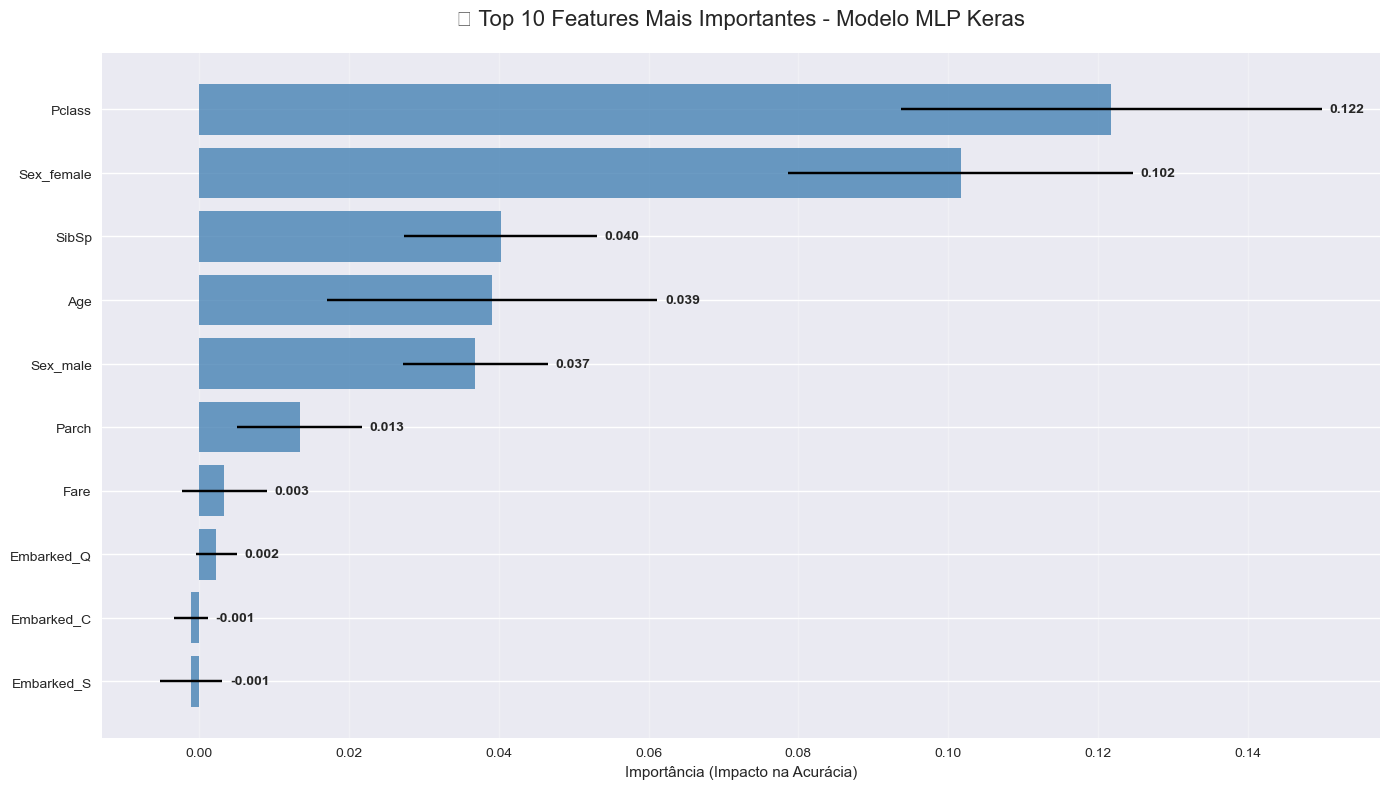


 TOP 5 FEATURES MAIS IMPORTANTES:
---------------------------------------------
1. Pclass                    0.1218 ± 0.0281
2. Sex_female                0.1017 ± 0.0230
3. SibSp                     0.0402 ± 0.0129
4. Age                       0.0391 ± 0.0221
5. Sex_male                  0.0369 ± 0.0097

PREDIÇÕES NO CONJUNTO DE TESTE:
---------------------------------------------
Total de passageiros no teste: 418
Sobreviventes preditos: 166
Taxa de sobrevivência predita: 39.7%
Taxa de sobrevivência original: 38.4%
• Versão do Keras          : 3.10.0
• Épocas de Treinamento    : 31
• Melhor Acurácia (Validação): 82.1%
• Acurácia Final (Validação): 82.1%
• Total de Features        : 10
• Parâmetros Treináveis    : 2,817
• Tamanho do Dataset       : Treino: 712 | Validação: 179
• Alinhamento Histórico    : Excelente (diff: 1.3%)


In [12]:
# Análise de Importância das Features e Resultados Finais
from sklearn.inspection import permutation_importance

print("🔍 CALCULANDO IMPORTÂNCIA DAS FEATURES...")
print("="*60)

# Função de scoring simplificada para Keras
def keras_accuracy_scorer(model, X, y):
    predictions = (model.predict(X, verbose=0) > 0.5).astype(int).flatten()
    return accuracy_score(y, predictions)

# Calcular importância das features
perm_importance = permutation_importance(
    model, X_val_scaled, y_val, 
    n_repeats=5, 
    random_state=42,
    scoring=keras_accuracy_scorer
)

# Criar DataFrame ordenado por importância
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importância': perm_importance.importances_mean,
    'Desvio': perm_importance.importances_std
}).sort_values('Importância', ascending=False)

# Visualização da importância das features
plt.figure(figsize=(14, 8))
top_10 = importance_df.head(10)

# Gráfico de barras horizontais
bars = plt.barh(range(len(top_10)), top_10['Importância'], 
                xerr=top_10['Desvio'], alpha=0.8, color='steelblue')
plt.yticks(range(len(top_10)), top_10['Feature'])
plt.xlabel('Importância (Impacto na Acurácia)')
plt.title('🎯 Top 10 Features Mais Importantes - Modelo MLP Keras', fontsize=16, pad=20)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Adicionar valores nas barras
for i, (importance, std) in enumerate(zip(top_10['Importância'], top_10['Desvio'])):
    plt.text(importance + std + 0.001, i, f'{importance:.3f}', 
             va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Exibir top 5 features
print("\n TOP 5 FEATURES MAIS IMPORTANTES:")
print("-" * 45)
for i, (_, row) in enumerate(top_10.head(5).iterrows(), 1):
    print(f"{i}. {row['Feature']:<25} {row['Importância']:.4f} ± {row['Desvio']:.4f}")

# Predições no conjunto de teste
print("\nPREDIÇÕES NO CONJUNTO DE TESTE:")
print("-" * 45)
test_predictions = (model.predict(X_test_scaled, verbose=0) > 0.5).astype(int).flatten()
survival_rate_predicted = sum(test_predictions) / len(test_predictions)
survival_rate_original = train_df['Survived'].mean()

print(f"Total de passageiros no teste: {len(test_predictions)}")
print(f"Sobreviventes preditos: {sum(test_predictions)}")
print(f"Taxa de sobrevivência predita: {survival_rate_predicted:.1%}")
print(f"Taxa de sobrevivência original: {survival_rate_original:.1%}")

# Salvar arquivos
model.save("modelo_titanic_keras.keras")
submission_df = pd.DataFrame({
    'PassengerId': range(892, 892 + len(test_predictions)),
    'Survived': test_predictions
})
submission_df.to_csv('titanic_submission_keras.csv', index=False)


# Métricas principais
final_metrics = {
    'Versão do Keras': keras.__version__,
    'Épocas de Treinamento': len(history.history['loss']),
    'Melhor Acurácia (Validação)': f"{max(history.history['val_accuracy']):.1%}",
    'Acurácia Final (Validação)': f"{val_accuracy:.1%}",
    'Total de Features': len(X.columns),
    'Parâmetros Treináveis': f"{model.count_params():,}",
    'Tamanho do Dataset': f"Treino: {len(X_train)} | Validação: {len(X_val)}"
}

for key, value in final_metrics.items():
    print(f"• {key:<25}: {value}")


# Diferença entre predições e dados históricos
difference = abs(survival_rate_original - survival_rate_predicted)
alignment = "Excelente" if difference < 0.05 else "Bom" if difference < 0.1 else "Moderado"
print(f"• {'Alinhamento Histórico':<25}: {alignment} (diff: {difference:.1%})")
